### Importing whats is necessary to get started

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Set all seed to make our experiment reproductibly

np.random.seed(42)
random_state = 42

/home/navar/anaconda3/envs/fogocruzado/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/navar/anaconda3/envs/fogocruzado/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
data_path = '../data/interim/'
data_name = 'Bairos_location_and_counts.csv'
data = pd.read_csv(data_path + data_name)
data.head()

,BAIRRO,LATITUDE,LONGITUDE,GUNFIRE
0,Abolição,-22.880501,-43.301851,2
1,Acari,-22.825152,-43.343935,39
2,Agostinho Porto,-22.787647,-43.384603,10
3,Alcântara,-22.821032,-43.001838,5
4,Aldeia da Prata,-22.767581,-42.936585,1


That is our subset of data. I am really curious if we can predict gunfires in neighborhoods. It can be modeled as as Regression problem, let's start simple and explore a few model.

## Data preparation

First of all I am going to set aside RANDOMLY 20% of samples and never look at it before deliery my model into the pipeline. I want to remove as most sampling bias as possible.

In [3]:
from sklearn.model_selection import train_test_split

data_to_use, data_to_set_aside = train_test_split(data, test_size = 0.2, shuffle=True)

In [4]:
print("Number of samples in train set: {}".format(len(data_to_use)))
print("Number of samples in test set: {}".format(len(data_to_set_aside)))

Number of samples in train set: 427
Number of samples in test set: 107


In [5]:
data_to_set_aside.to_csv(data_path + 'Bairos_location_and_counts__final.csv')

### Models definitions

I'd like to star simple:

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

# The statistical test for model selection is cross-validation.
# The metrics we are going to optmize is RMSE

from sklearn.model_selection import cross_val_score

Separate data into numpy arrays with both features and labels.

In [7]:
X = data_to_use.iloc[:,1:3]
y = data_to_use.iloc[:,-1]

Let's not worry about tunning hyperameters from now and use the default settings.

In [8]:
lin_reg = LinearRegression()
tree_reg = DecisionTreeRegressor(random_state=random_state)

In [9]:
lin_reg_pred = cross_val_score(lin_reg, X,y, cv=10, scoring="neg_mean_squared_error")
tree_reg_pred = cross_val_score(tree_reg, X,y, cv=10, scoring="neg_mean_squared_error")

Since scikit-learn has no RMSE as score, we are going to use negative MSE and apply further transformation.

In [10]:
reg_scores = np.array([lin_reg_pred,tree_reg_pred])
reg_scores = np.sqrt(-1*reg_scores)

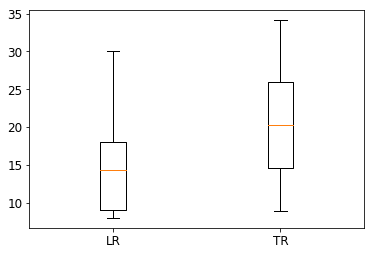

In [11]:
plt.boxplot([reg_scores[0], reg_scores[1]])
plt.xticks([1,2], ['LR', 'TR'])
plt.show()

Linear Regression was a little better than decision tree. Let's try Random forest to see where it gets us.

/home/navar/anaconda3/envs/fogocruzado/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


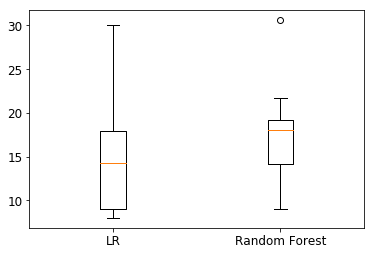

In [12]:
from sklearn.ensemble import RandomForestRegressor

random_forest_reg = RandomForestRegressor(random_state=random_state)
random_forest_reg_pred = cross_val_score(random_forest_reg, X,y, cv=10, scoring="neg_mean_squared_error")

reg_scores = np.array([lin_reg_pred, random_forest_reg_pred])
reg_scores = np.sqrt(-1*reg_scores)

plt.boxplot([reg_scores[0], reg_scores[1]])
plt.xticks([1,2], ['LR', 'Random Forest'])
plt.show()

Random Forest seems promissing. Before tweaking our model let's take a different look of its predictions.

In [13]:
from src.data import Cleaning

clean_03 = Cleaning.GetData_lat_long(coordinates=(-43.5, -43.2, -23.05, -22.8))
data_selected = clean_03.fit_transform(data_to_use)

In [14]:
X = data_selected.iloc[:,1:3]
y = data_selected.iloc[:,-1]

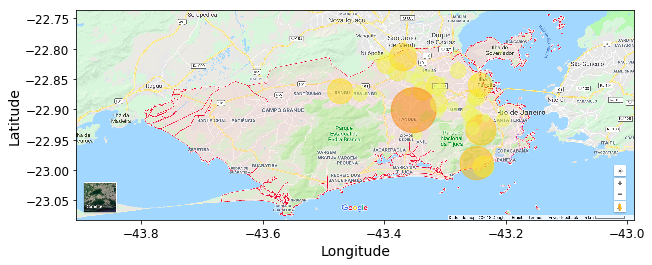

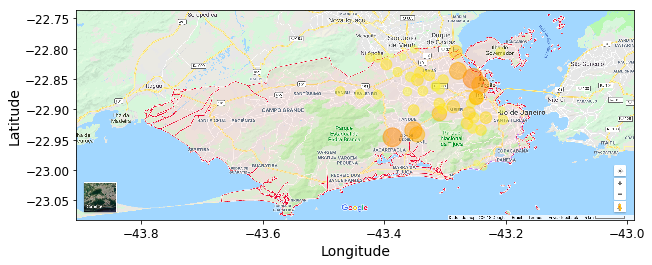

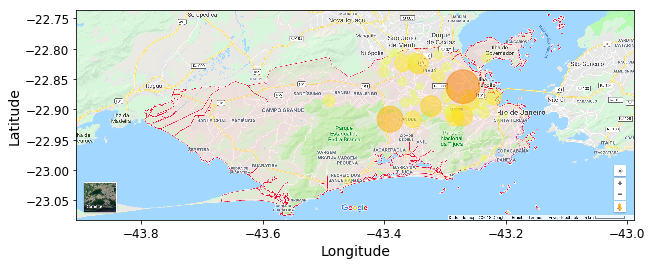

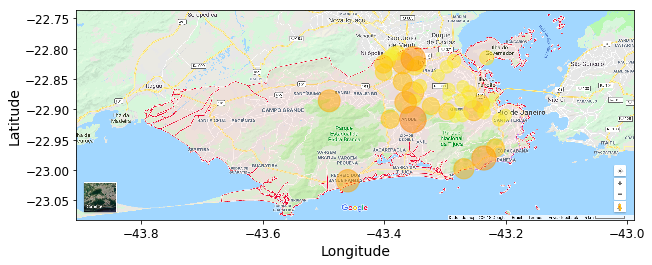

In [27]:
from sklearn.model_selection import KFold
from src.visualization import visualize

kf = KFold(n_splits=2, random_state=random_state, shuffle=True)

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    random_forest_reg.fit(X_train, y_train)
    y_pred = random_forest_reg.predict(X_test)
    
    # Create real data
    data_real = pd.concat([X_test, y_test], axis=1)
    # Create predicted data
    data_pred = pd.concat([X_test, pd.DataFrame(y_pred, columns=['GUNFIRE'], index=X_test.axes[0])], axis=1)
       
#     print(data_pred)
    
    visualize.plt_Rio_city(figsize=(10,10))
    visualize.plt_density(data_real, s=10)
    plt.show()
    
    visualize.plt_Rio_city(figsize=(10,10))
    visualize.plt_density(data_pred, s=10)
    plt.show()

In [18]:
data_pred

,LATITUDE,LONGITUDE,GUNFIRE
0,NaN,NaN,50.2
1,-22.825152,-43.343935,40.3
2,NaN,NaN,12.3
3,NaN,NaN,32.6
4,NaN,NaN,7.6
5,NaN,NaN,15.0
6,NaN,NaN,44.9
7,NaN,NaN,33.5
8,NaN,NaN,46.7
9,NaN,NaN,10.4


Feed to the model and compare

In [16]:
y_pred = random_forest_reg.predict(X_train)

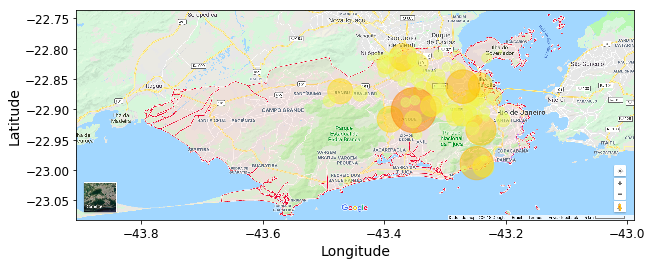

In [17]:
from src.visualization import visualize

visualize.plt_Rio_city(figsize=(10,10))
visualize.plt_density(data_selected, s=10)
plt.show()